In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import shap
import pickle

# import tensorflow

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Activation, Dropout
import tensorflow as tf

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset = pd.read_csv('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/dataset.csv')

# Data Preperation

## Size up 'race' feature

In [9]:
dataset = dataset.drop(columns=['hadm_id'])

In [10]:
dataset['Length of ICU stay'] = dataset['Length of ICU stay']/ (24*60*60)

In [11]:
dataset['race'] = dataset['race'].str.replace(r'.*AFRICAN AMERICAN.*', 'African american', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*WHITE.*', 'White', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*HISPANIC.*', 'Hispanic', regex=True)
dataset.loc[~dataset['race'].isin(['White', 'African american', 'Hispanic']), 'race'] = 'Other'
dataset['gender'] = dataset['gender'].str.replace(r'.*M.*', 'Male', regex=True)
dataset['gender'] = dataset['gender'].str.replace(r'.*F.*', 'Female', regex=True)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  int64  
 2   gender                                   30096 non-null  object 
 3   race                                     30096 non-null  object 
 4   mortality                                30096 non-null  int64  
 5   Minimum creatinine                       29865 non-null  float64
 6   Maximum creatinine                       29865 non-null  float64
 7   Maximum creatinine during day2 and day3  29792 non-null  float64
 8   Maximum heart rate                       30035 non-null  float64
 9   Mean heart rate                          30035 non-null  float64
 10  Minimum systolic bp                      26528

## Eliminatie outliers

In [13]:
# eliminate outliers
dataset_copy = dataset.copy()
predictors_continuous = dataset_copy.drop(columns=['gender', 'race', 'mortality'])

predictors_continuous['Maximum creatinine'] = predictors_continuous['Maximum creatinine'].where(predictors_continuous['Maximum creatinine'] <= 50, np.nan)
predictors_continuous['Minimum creatinine'] = predictors_continuous['Minimum creatinine'].where(predictors_continuous['Minimum creatinine'] <= 50, np.nan)
predictors_continuous['Maximum creatinine during day2 and day3'] = predictors_continuous['Maximum creatinine during day2 and day3'].where(predictors_continuous['Maximum creatinine during day2 and day3'] <= 1000, np.nan)

predictors_continuous['Maximum heart rate'] = predictors_continuous['Maximum heart rate'].where(predictors_continuous['Maximum heart rate'] <= 300, np.nan)
predictors_continuous['Mean heart rate'] = predictors_continuous['Mean heart rate'].where(predictors_continuous['Mean heart rate'] <= 300, np.nan)

predictors_continuous['Minimum spo2'] = predictors_continuous['Minimum spo2'].where(predictors_continuous['Minimum spo2'] <= 100, np.nan)
predictors_continuous['Mean spo2'] = predictors_continuous['Mean spo2'].where(predictors_continuous['Mean spo2'] <= 100, np.nan)

predictors_continuous['Minimum prothrombin'] = predictors_continuous['Minimum prothrombin'].where(predictors_continuous['Minimum prothrombin'] <= 1000, np.nan)
predictors_continuous['Maximum prothrombin'] = predictors_continuous['Maximum prothrombin'].where(predictors_continuous['Maximum prothrombin'] <= 1000, np.nan)

predictors_continuous['Mean systolic bp'] = predictors_continuous['Mean systolic bp'].where(predictors_continuous['Mean systolic bp'] <= 500, np.nan)

predictors_continuous['Mean diastolic bp'] = predictors_continuous['Mean diastolic bp'].where(predictors_continuous['Mean diastolic bp'] <= 2000, np.nan)

predictors_continuous['Maximum respiratory rate'] = predictors_continuous['Maximum respiratory rate'].where(predictors_continuous['Maximum respiratory rate'] <= 500, np.nan)

predictors_continuous['Mean respiratory rate'] = predictors_continuous['Mean respiratory rate'].where(predictors_continuous['Mean respiratory rate'] <= 500, np.nan)

predictors_continuous['Maximum sodium'] = predictors_continuous['Maximum sodium'].where(predictors_continuous['Maximum sodium'] <= 500, np.nan)

# predictors_continuous['Sodium Mean'].plot()
# predictors_continuous.info()

In [14]:
mean = predictors_continuous.mean(axis=0, skipna=True)
std = predictors_continuous.std(axis=0, skipna=True)
pd.DataFrame({'Mean': mean, 'Std': std})
# predictors_continuous.info()

,Mean,Std
stay_id,3.498016e+07,2.889898e+06
Age,6.620066e+01,1.504369e+01
Minimum creatinine,1.467875e+00,1.498831e+00
Maximum creatinine,1.693178e+00,1.758836e+00
Maximum creatinine during day2 and day3,1.694666e+00,1.693505e+00
Maximum heart rate,1.281930e+02,1.219978e+01
Mean heart rate,8.670237e+01,1.383710e+01
Minimum systolic bp,9.346460e+01,1.896775e+01
Mean systolic bp,1.170704e+02,1.844904e+01
Minimum diastolic bp,4.775952e+01,1.282603e+01


In [15]:
predictors_categorical = dataset_copy[['stay_id', 'gender', 'race']]
predictors_categorical['gender'].value_counts()
predictors_categorical['race'].value_counts() / predictors_categorical['race'].count()
# predictors_categorical.info()

White               0.675472
Other               0.196870
African american    0.093169
Hispanic            0.034490
Name: race, dtype: float64

## Complete the missing values

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [17]:
df_raw = predictors_continuous.copy()
missing_mask = df_raw.isna()
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(df_raw)
imputed_df = pd.DataFrame(imputed_values, index=df_raw.index, columns=df_raw.columns)

In [18]:
df_raw[missing_mask] = imputed_df[missing_mask]
predictors_continuous = df_raw.copy()

In [19]:
predictors_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  int64  
 2   Minimum creatinine                       30096 non-null  float64
 3   Maximum creatinine                       30096 non-null  float64
 4   Maximum creatinine during day2 and day3  30096 non-null  float64
 5   Maximum heart rate                       30096 non-null  float64
 6   Mean heart rate                          30096 non-null  float64
 7   Minimum systolic bp                      30096 non-null  float64
 8   Mean systolic bp                         30096 non-null  float64
 9   Minimum diastolic bp                     30096 non-null  float64
 10  Mean diastolic bp                        30096

## Normaliztion

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
temp = predictors_continuous.iloc[:, 1:]

columns = temp.columns
temp_normalized = scaler.fit_transform(temp)

temp1 = pd.DataFrame(temp_normalized, columns=columns)

predictors_continuous = pd.concat([predictors_continuous['stay_id'], temp1], axis=1)

In [23]:
predictors_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  float64
 2   Minimum creatinine                       30096 non-null  float64
 3   Maximum creatinine                       30096 non-null  float64
 4   Maximum creatinine during day2 and day3  30096 non-null  float64
 5   Maximum heart rate                       30096 non-null  float64
 6   Mean heart rate                          30096 non-null  float64
 7   Minimum systolic bp                      30096 non-null  float64
 8   Mean systolic bp                         30096 non-null  float64
 9   Minimum diastolic bp                     30096 non-null  float64
 10  Mean diastolic bp                        30096

## Get the data that will be used for fitting model

In [24]:
y = dataset_copy['mortality']
X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
X = X.drop(columns=['stay_id'])
variables_cont = X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(X['gender'], drop_first=True)
variable_race = pd.get_dummies(X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)


In [25]:
feature_names = X.columns
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30096 entries, 0 to 30095
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Age                                      30096 non-null  float64
 1   Minimum creatinine                       30096 non-null  float64
 2   Maximum creatinine                       30096 non-null  float64
 3   Maximum creatinine during day2 and day3  30096 non-null  float64
 4   Maximum heart rate                       30096 non-null  float64
 5   Mean heart rate                          30096 non-null  float64
 6   Minimum systolic bp                      30096 non-null  float64
 7   Mean systolic bp                         30096 non-null  float64
 8   Minimum diastolic bp                     30096 non-null  float64
 9   Mean diastolic bp                        30096 non-null  float64
 10  Minimum spo2                             30096

In [26]:
X = X.to_numpy()
y = y.to_numpy()

In [27]:
X.shape

(30096, 38)

In [28]:
X = X.reshape(30096, 38,1)
y = y.reshape(30096,1)

In [29]:
X.shape

(30096, 38, 1)

# plot initial selelction

In [37]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=0)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
from keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from tensorflow.keras.metrics import TrueNegatives, FalsePositives, TrueNegatives, FalseNegatives

class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = TrueNegatives()
        self.false_positives = FalsePositives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Assuming y_pred are probabilities
        self.true_negatives.update_state(y_true, y_pred, sample_weight)
        self.false_positives.update_state(y_true, y_pred, sample_weight)

    def result(self):
        specificity = self.true_negatives.result() / (self.true_negatives.result() + self.false_positives.result())
        return specificity

    def reset_state(self):
        self.true_negatives.reset_states()
        self.false_positives.reset_states()

    def get_config(self):
        base_config = super(Specificity, self).get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class NPV(tf.keras.metrics.Metric):
    def __init__(self, name='npv', **kwargs):
        super(NPV, self).__init__(name=name, **kwargs)
        self.true_negatives = TrueNegatives()
        self.false_negatives = FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Assuming y_pred are probabilities
        self.true_negatives.update_state(y_true, y_pred, sample_weight)
        self.false_negatives.update_state(y_true, y_pred, sample_weight)

    def result(self):
        npv = self.true_negatives.result() / (self.true_negatives.result() + self.false_negatives.result())
        return npv

    def reset_state(self):
        self.true_negatives.reset_states()
        self.false_negatives.reset_states()

    def get_config(self):
        base_config = super(NPV, self).get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [38]:
baseline_CNN = tf.keras.models.load_model("/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN", custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_CNN.evaluate(X_test, y_test, verbose=1)

48/48 [==============================] - 3s 6ms/step - loss: 0.5687 - binary_accuracy: 0.6997 - auc: 0.7741 - ppv: 0.6985 - sensitivity: 0.6118 - specificity: 0.7746 - npv: 0.7004


[0.5687335729598999,
 0.699667751789093,
 0.7740983366966248,
 0.6985173225402832,
 0.6118326187133789,
 0.7746305465698242,
 0.7004454135894775]

In [41]:
baseline_RNN = tf.keras.models.load_model('/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_RNN', custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_RNN.evaluate(X_test, y_test, verbose=1)

48/48 [==============================] - 1s 3ms/step - loss: 0.5873 - binary_accuracy: 0.6897 - auc: 0.7536 - ppv: 0.6846 - sensitivity: 0.6046 - specificity: 0.7623 - npv: 0.6932


[0.5872515439987183,
 0.6897010207176208,
 0.7536377310752869,
 0.6846405267715454,
 0.6046175956726074,
 0.7623152732849121,
 0.693169116973877]

In [42]:
baseline_LSTM = tf.keras.models.load_model('/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_LSTM', custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_LSTM.evaluate(X_test, y_test, verbose=1)

48/48 [==============================] - 1s 6ms/step - loss: 0.5766 - binary_accuracy: 0.7076 - auc: 0.7678 - ppv: 0.7030 - sensitivity: 0.6320 - specificity: 0.7722 - npv: 0.7109


[0.5765758156776428,
 0.7076411843299866,
 0.767754077911377,
 0.7030497789382935,
 0.6320346593856812,
 0.7721675038337708,
 0.7108843326568604]

In [43]:
y_probs_CNN = baseline_CNN.predict(X_test).reshape(X_test.shape[0], 1)
fpr_CNN, tpr_CNN, thresholds = roc_curve(y_test.reshape(X_test.shape[0], 1), y_probs_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)

y_probs_RNN = baseline_RNN.predict(X_test).reshape(X_test.shape[0], 1)
fpr_RNN, tpr_RNN, thresholds = roc_curve(y_test.reshape(X_test.shape[0], 1), y_probs_RNN)
roc_auc_RNN = auc(fpr_RNN, tpr_RNN)

y_probs_LSTM = baseline_LSTM.predict(X_test).reshape(X_test.shape[0], 1)
fpr_LSTM, tpr_LSTM, thresholds = roc_curve(y_test.reshape(X_test.shape[0], 1), y_probs_LSTM)
roc_auc_LSTM = auc(fpr_LSTM, tpr_LSTM)

48/48 [==============================] - 1s 9ms/step


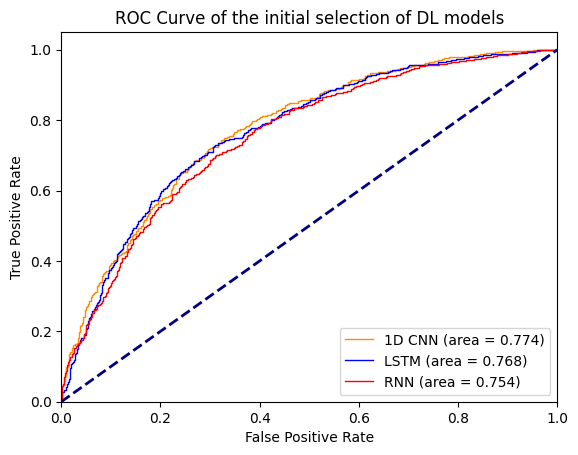

In [58]:
# Plot ROC curve
plt.figure()

plt.plot(fpr_CNN, tpr_CNN, color='darkorange', lw=1, label=f'1D CNN (area = {roc_auc_CNN:.3f})')
plt.plot(fpr_LSTM, tpr_LSTM, color='blue', lw=1, label=f'LSTM (area = {roc_auc_LSTM:.3f})')
plt.plot(fpr_RNN, tpr_RNN, color='red', lw=1, label=f'RNN (area = {roc_auc_RNN:.3f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the initial selection of DL models')
plt.legend(loc="lower right")
plt.show()

# plot backward selelction

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=0)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [47]:
X_test_CNNback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/X_test_CNNback.npy')
y_test_CNNback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/y_test_CNNback.npy')
baseline_CNN_backward = tf.keras.models.load_model('/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_CNN_backward', custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_CNN_backward.evaluate(X_test_CNNback, y_test_CNNback, verbose=1)

48/48 [==============================] - 0s 2ms/step - loss: 0.5739 - binary_accuracy: 0.7030 - auc: 0.7699 - ppv: 0.6894 - sensitivity: 0.6425 - specificity: 0.7543 - npv: 0.7131


[0.5738965272903442,
 0.7029900550842285,
 0.7699075937271118,
 0.6894409656524658,
 0.6425470113754272,
 0.7542997598648071,
 0.7131242752075195]

In [51]:
X_test_RNNback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/X_test_RNNback.npy')
y_test_RNNback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/y_test_RNNback.npy')
baseline_RNN_backward = tf.keras.models.load_model('/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_RNN_backward', custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_RNN_backward.evaluate(X_test_RNNback, y_test_RNNback, verbose=1)

48/48 [==============================] - 1s 4ms/step - loss: 0.5770 - binary_accuracy: 0.6897 - auc: 0.7583 - ppv: 0.6628 - sensitivity: 0.6060 - specificity: 0.7560 - npv: 0.7079


[0.577043890953064,
 0.6897010207176208,
 0.7583019733428955,
 0.6628289222717285,
 0.6060150265693665,
 0.7559523582458496,
 0.7079152464866638]

In [62]:
X_test_LSTMback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/X_test_LSTMback.npy')
y_test_LSTMback = np.load('/content/drive/MyDrive/Project_1_with_ye/Code/model/y_test_LSTMback.npy')
baseline_LSTM_backward = tf.keras.models.load_model('/content/drive/MyDrive/Project_1_with_ye/Code/model/baseline_LSTM_backward', custom_objects={'Specificity': Specificity, 'NPV': NPV})
baseline_LSTM.evaluate(X_test_LSTMback, y_test_LSTMback, verbose=1)

48/48 [==============================] - 0s 5ms/step - loss: 0.5792 - binary_accuracy: 0.7043 - auc: 0.7590 - ppv: 0.6692 - sensitivity: 0.6602 - specificity: 0.7395 - npv: 0.7317


[0.5792455077171326,
 0.7043189406394958,
 0.7589552402496338,
 0.6691957712173462,
 0.660179615020752,
 0.739546000957489,
 0.7316784858703613]

In [67]:
y_probs_CNN = baseline_CNN_backward.predict(X_test_CNNback).reshape(X_test_CNNback.shape[0], 1)
fpr_CNN, tpr_CNN, thresholds = roc_curve(y_test_CNNback.reshape(X_test_CNNback.shape[0], 1), y_probs_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)

y_probs_RNN = baseline_RNN_backward.predict(X_test_RNNback).reshape(X_test_RNNback.shape[0], 1)
fpr_RNN, tpr_RNN, thresholds = roc_curve(y_test_RNNback.reshape(X_test_RNNback.shape[0], 1), y_probs_RNN)
roc_auc_RNN = auc(fpr_RNN, tpr_RNN)

y_probs_LSTM = baseline_LSTM_backward.predict(X_test_LSTMback).reshape(X_test_LSTMback.shape[0], 1)
fpr_LSTM, tpr_LSTM, thresholds = roc_curve(y_test_LSTMback.reshape(X_test_LSTMback.shape[0], 1), y_probs_LSTM)
roc_auc_LSTM = auc(fpr_LSTM, tpr_LSTM)

48/48 [==============================] - 0s 4ms/step


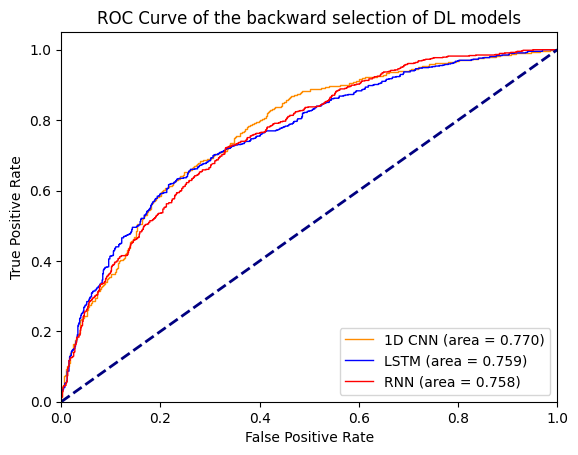

In [68]:
# Plot ROC curve
plt.figure()

plt.plot(fpr_CNN, tpr_CNN, color='darkorange', lw=1, label=f'1D CNN (area = {roc_auc_CNN:.3f})')
plt.plot(fpr_LSTM, tpr_LSTM, color='blue', lw=1, label=f'LSTM (area = {roc_auc_LSTM:.3f})')
plt.plot(fpr_RNN, tpr_RNN, color='red', lw=1, label=f'RNN (area = {roc_auc_RNN:.3f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the backward selection of DL models')
plt.legend(loc="lower right")
plt.show()